<img src="20190314_ns19_logo.png" style="width:500px">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   

<h1> Using the Allen SDK to find and access data </h1>

<h3> SFN 2019 Satellite Event, Saturday, October 19, 2019 </h3>

In this tutorial, we are going to explore how to access Neuropixels data from the Allen Brain Observatory through the AllenSDK. You will learn how to download datasets as well as how to access important components of the data such as spike times and metadata for the experimental sessions, among other things.

Prerequesites:

EITHER

- a Python environment (we suggest Anaconda:  https://www.anaconda.com/distribution/)


- Install allensdk: http://alleninstitute.github.io/AllenSDK/install.html
``` 
$ pip install allensdk```

OR

- Spin up AWS instance: https://github.com/AllenInstitute/AllenSDK/wiki/Use-the-Allen-Brain-Observatory-%E2%80%93-Visual-Coding-on-AWS

(Note:  if you work through the tutorials locally, i.e. not using AWS, you will be downloading datasets to your local drive.  This can be slow.)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# tab completion in the notebook sometimes has trouble with large dataframes
# this will fix it
%config Completer.use_jedi = False

In [2]:
import platform
platstring = platform.platform()

if ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/"
else:
    # then your own platform
    # EDIT location where you want the data to be stored
    data_root = "/mnt/hdd0/cache_dir_10_15"

manifest_path = os.path.join(data_root, "manifest.json")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
<h2>Getting started</h2>
<p>The <code>EcephyProjectCache</code> class should be the starting point for your analysis sessions. It points to a cache directory, which can be on your local machine, on a hard drive, or in the cloud. For this workshop, all of the data is available on AWS.
    
If you request data that's not already stored in the cache directory, it will be automatically downloaded for you. Data only needs to be downloaded once—after that, it can be loaded directly from the cache.

The first step is to import the `EcephysProjectCache` class and create a new cache object.

The location of the cache is determined by the <code>manifest_path</code>, which was set in the previous cell. In this case, it should point to an existing cache directory on AWS. But if you want to run this code outside the workshop, you would have to specify your own storage location.
</div>


In [3]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# 1. Exploring available sessions of the dataset

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Get information about what's in the Neuropixels dataset from EcephysProjectCache

<p>Use the <code>get_session_table</code> function to retrieve a dataframe of all the available sessions. What information does this dataframe contain?

- How many sessions are there in the dataset?
- What is the average number of units in an experiment? The max number? The minimum?
- What are the different genotypes that were used in these experiments? How many sessions per genotype?
- What are all the brain structures that data has been collected from?
</div>

In [4]:
sessions = cache.get_session_table()

How many sessions are available?

In [5]:
sessions.shape[0]

58

What's the average number of units in a session? The max? The min?

In [6]:
print(sessions.unit_count.mean())
print(sessions.unit_count.max())
print(sessions.unit_count.min())

689.8275862068965
1005
415


Text(0, 0.5, '# sessions')

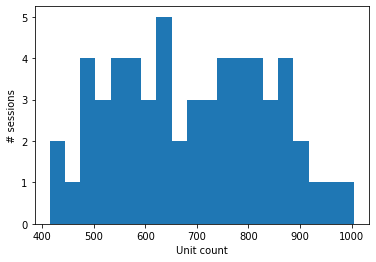

In [7]:
plt.hist(sessions.unit_count, bins=20);
plt.xlabel("Unit count")
plt.ylabel("# sessions")

What are the different genotypes that were used for this dataset? How many sessions per genotype are available?

In [8]:
sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Name: full_genotype, dtype: int64

What are the different session types? How many sessions per type?

In [9]:
sessions.session_type.value_counts()

brain_observatory_1.1      32
functional_connectivity    26
Name: session_type, dtype: int64

What are all the structures that data has been collected from?

In [10]:
all_areas = []
for index,row in sessions.iterrows():
    for a in row.ecephys_structure_acronyms:
        if a not in all_areas:
            all_areas.append(a)

In [11]:
print(all_areas)

['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT', 'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL', 'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS', 'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL', 'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP', 'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'RT', 'SCop', 'SCsg', 'SCzo']


To get more information about these structures, visit [our reference atlas web app](http://atlas.brain-map.org/atlas?atlas=602630314).

How many sessions have data from VISp?

In [12]:
count=0
for index,row in sessions.iterrows():
    if 'VISp' in row.ecephys_structure_acronyms:
        count+=1
print(count)

56


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
<h2>The session object</h2>
<p>The session object allows you to access all the data and metadata for a single experiment session, including spike times, stimulus information, unit waveforms, LFP, and the mouse's running speed. 

<p>The session object is created by <code>cache.get_session_data(session_id)</code>. Some data can be accessed directly as an attribute of the class, others by using 'get' functions. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  Let's pick one session to examine in greater detail. Select a `brain_observatory_1.1` session. Feel free to use other metadata to select one session and get the session_id (the index).

</div>

In [13]:
session_id = sessions[(sessions.unit_count>500) & (sessions.session_type=='brain_observatory_1.1')
                      &(sessions.full_genotype=='wt/wt')].index[0]
print(session_id)

732592105


Which structures were recorded from in this session?

In [14]:
sessions.ecephys_structure_acronyms[session_id]

array(['grey', 'VISpm', nan, 'VISp', 'VISl', 'VISal', 'VISrl'],
      dtype=object)

If the session only contains cortical structures ('VIS' acronym, which stands for visual cortex), it means that the probes from this session haven't been registered to the Common Coordinate Framework. All the data is still available, but only the location of cortical channels has been validated.

Let's pick a different session that has more structures available.

In [15]:
session_id = sessions[(sessions.unit_count>500) & (sessions.session_type=='brain_observatory_1.1')
                      &(sessions.full_genotype=='wt/wt')].index[5]

print(session_id)

sessions.ecephys_structure_acronyms[session_id]

744228101


array(['Eth', 'TH', 'LP', 'POL', 'APN', 'DG', 'CA1', 'VIS', nan, 'CA3',
       'VISrl', 'VPL', 'IGL', 'LGd', 'CA2', 'VISal', 'VISl', 'SGN', 'SUB',
       'VISp'], dtype=object)

This one contains units from the thalamus (LP, LGd), hippocampal formation (CA1, CA3, DG), and cortex, among other structures.

Let's take a closer look at it!

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3:</b>  Get the data for this session.  

<p> Use the <code>get_session_data</code> function of the cache to access the session object for this session. This object will load data from the underlying NWB file whenever it's requested.
</div>

In [16]:
session = cache.get_session_data(session_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
    
<h2> 2. Unit properties</h2>

<p> Most of your analysis of Neuropixels data will likely focus on spike trains. We use
    <a href="https://github.com/mouseland/kilosort2">Kilosort2</a> to extract spike times from the original continuously sampled data, and to associate each spike with a particular unit. We use the term 'units', rather than 'cells', because we cannot guarantee that every spike in a spike train actually comes from one neuron. Unlike in two-photon imaging, where you can see the cell throughout the entire recording, with ephys we can only 'see' a cell when it fires a spike. If a cell moves relative to the probe, or if it's far away from the probe, some of its spikes may get mixed together with those from other cells.
    
Because of this inherent ambiguity, we provide a variety of quality metrics to allow you to find the right units for your analysis. Even highly contaminated units contain potentially valuable information about brain states, so we didn't want to leave them out of the dataset. But certain types of analysis require more stringent quality thresholds, to ensure that all of the units are well isolated.
    
<code>session.units</code> will return a dataframe containing metrics for the units for one session. These metrics include:
</p>
<ul>
<li> <b>firing_rate:</b> mean spike rate throughout the entire session; units will very low firing rates (less than 0.1 Hz) can be difficult to isolate
<li> <b>presence_ratio:</b> fraction of the session for which spikes are present; if a unit drifts out of the recording, it will have a low presence ratio. By default, we only return units with a presence ratio greater than 0.95
<li> <b>isi_violations:</b> rate of refractory period violations; higher values for ISI violations indicate greater contamination. By default, we only return units with ISI violation less than 0.5
<li> <b>amplitude_cutoff:</b> roughly proportional to the fraction of missing spikes; for low-amplitude units, some spikes will not be detected, resulting in a higher amplitude cutoff. By default, we only return units with an amplitude cutoff less than 0.1 
</ul>

The default thresholds were chosen to return units that are missing less than 10% of spikes, are present throughout the duration of the recording, and are relatively un-contaminated. If you want access to all of the units from the recording, or want to set a different threshold for one of these metrics, you can {DO THIS}

The units table also includes metrics computed from the spike waveform, such as the amplitude, peak-to-trough ratio, and duration (see below).

<b>1D Waveform features:</b>

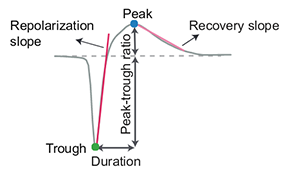

For more information on the unit metrics:

https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/quality_metrics
https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms

</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1: Units</b>  

<p> Get the `units` dataframe for this session. 

What the the metrics? (i.e. what are the columns for the dataframe?

How many units are there? How many units per structure?
</div>

In [17]:
session.units.head()

,waveform_spread,silhouette_score,waveform_PT_ratio,waveform_amplitude,local_index_unit,L_ratio,d_prime,amplitude_cutoff,nn_hit_rate,waveform_velocity_above,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951773968,40.0,0.023816,0.640688,114.786945,4,0.007553,4.594217,0.029609,0.992667,0.206030,...,215.0,APN,7848,3152,6806,probeA,,29999.962297,1249.998429,True
951773987,60.0,0.142609,0.590508,74.435595,9,0.014093,3.043791,0.006487,0.968000,-0.068677,...,215.0,APN,7838,3129,6810,probeA,,29999.962297,1249.998429,True
951774009,60.0,0.052454,1.227057,61.310730,14,0.012127,2.572846,0.024603,0.979333,-0.343384,...,215.0,APN,7831,3114,6813,probeA,,29999.962297,1249.998429,True
951774042,60.0,0.134882,1.656495,129.899055,20,0.000251,4.519415,0.000788,0.998000,-0.480737,...,215.0,APN,7814,3075,6820,probeA,,29999.962297,1249.998429,True
951774078,70.0,0.043923,0.233868,84.936930,27,0.002930,4.450108,0.002083,0.996667,0.000000,...,215.0,APN,7800,3044,6826,probeA,,29999.962297,1249.998429,True


In [18]:
session.units.columns

Index(['waveform_spread', 'silhouette_score', 'waveform_PT_ratio',
       'waveform_amplitude', 'local_index_unit', 'L_ratio', 'd_prime',
       'amplitude_cutoff', 'nn_hit_rate', 'waveform_velocity_above',
       'isi_violations', 'waveform_recovery_slope', 'presence_ratio',
       'max_drift', 'waveform_repolarization_slope', 'cumulative_drift',
       'waveform_duration', 'snr', 'cluster_id', 'isolation_distance',
       'nn_miss_rate', 'firing_rate', 'waveform_halfwidth', 'peak_channel_id',
       'waveform_velocity_below', 'c50_dg', 'area_rf', 'fano_dg', 'fano_fl',
       'fano_ns', 'fano_rf', 'fano_sg', 'f1_f0_dg', 'g_dsi_dg', 'g_osi_dg',
       'g_osi_sg', 'azimuth_rf', 'mod_idx_dg', 'pref_sf_sg', 'pref_tf_dg',
       'run_mod_dg', 'run_mod_fl', 'run_mod_ns', 'run_mod_rf', 'run_mod_sg',
       'pref_ori_dg', 'pref_ori_sg', 'run_pval_dg', 'run_pval_fl',
       'run_pval_ns', 'run_pval_rf', 'run_pval_sg', 'elevation_rf',
       'p_value_rf', 'pref_image_ns', 'pref_phase_sg', 'firi

How many units are in this session?

In [19]:
session.units.shape[0]

659

Which areas (structures) are they from?

In [20]:
print(session.units.ecephys_structure_acronym.unique())

['APN' 'DG' 'CA1' 'VIS' 'Eth' 'TH' 'LP' 'POL' 'SGN' 'SUB' 'VISp' 'IGL'
 'CA3' 'VISl' 'VPL' 'LGd' 'CA2' 'VISal' 'VISrl']


How many units per area are there?

In [21]:
session.units.ecephys_structure_acronym.value_counts()

VIS      147
CA1      112
LP        84
Eth       44
VISal     41
SGN       39
VISp      35
SUB       34
VISrl     26
VISl      26
APN       20
IGL       13
DG        10
POL        9
CA3        9
VPL        6
TH         2
LGd        1
CA2        1
Name: ecephys_structure_acronym, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.2:</b> Select units from one probe to analyze in more detail.  

<p> <code>session.probes</code> contains information about the probes used in this experiment.

</div>

In [22]:
session.probes

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
757904508,probeA,,29999.962297,1249.998429,True
757904510,probeB,,29999.910883,1249.996287,True
757904513,probeC,,29999.991452,1249.999644,True
757904516,probeD,,29999.916422,1249.996518,True
757904520,probeE,,29999.992669,1249.999695,True
757904522,probeF,,30000.034924,1250.001455,True


Let's select probeC, which is typically inserted through primary visual cortex (VISp).

In [23]:
probe_id = session.probes.index.values[2]
units_to_analyze = session.units[session.units.probe_id == session.probes.index.values[2]]
len(units_to_analyze)

131

In [24]:
units_to_analyze.ecephys_structure_acronym.value_counts()

SGN     39
VISp    35
SUB     34
LP      23
Name: ecephys_structure_acronym, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.3:</b> Compare the firing rate of units in different structures

<p> Make a violinplot of the overall firing rates of units across structures.

</div>

In [25]:
import seaborn as sns

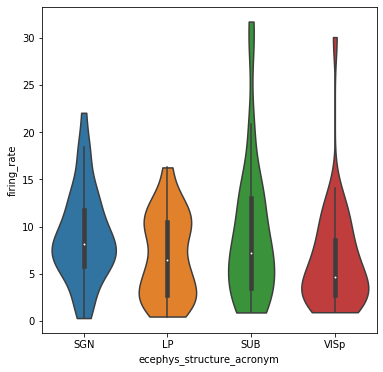

In [26]:
plt.figure(figsize=(6,6))
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',cut=0, bw=0.4, data=units_to_analyze)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.4:</b> Plot the location of the units on the probe

<p> Color each structure a different color. What do you learn about the vertical position values?

</div>

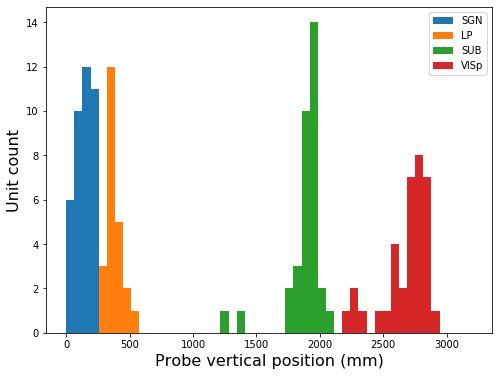

In [27]:
plt.figure(figsize=(8,6))
for structure in units_to_analyze.ecephys_structure_acronym.unique():
    plt.hist(units_to_analyze[units_to_analyze.ecephys_structure_acronym==structure].probe_vertical_position.values, bins=50, range=(0,3200), label=structure)
plt.legend()
plt.xlabel('Probe vertical position (mm)', fontsize=16)
plt.ylabel('Unit count', fontsize=16)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
    
<h2> 3. Spike times</h2>

<p> To analyze the spike times, we first have to access them.

</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.1: Spike Times</b>

<p> Next let's find the `spike_times` for these units.

</div>

In [28]:
spike_times = session.spike_times

What type of object is this?

In [29]:
type(spike_times)

dict

How many items does it include?

In [30]:
len(spike_times)

659

In [31]:
len(session.units)

659

What are the keys for this object?

In [32]:
list(spike_times.keys())[:5]

[951775418, 951775411, 951775390, 951775354, 951775615]

These keys are unit ids. Use the unit_id for the first unit to get the spike times for that unit. How many spikes does it have in the entire session?

In [33]:
spike_times[session.units.index[0]]

array([3.85575038e+00, 3.89721710e+00, 4.25975089e+00, ...,
       9.66184565e+03, 9.66188526e+03, 9.66192432e+03])

In [34]:
print(len(spike_times[session.units.index[0]]))

341188


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.2:</b> Plot the firing rate for one unit

<p> Use the spike times dictionary to plot the activity for one unit over the entire session.

</div>

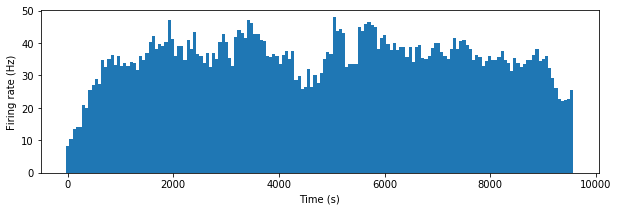

In [35]:
T = spike_times[session.units.index[0]]

bin_size = 60 # bin size in seconds
counts, bins = np.histogram(T, bins = np.arange(np.min(T), np.max(T), bin_size))

plt.figure(figsize=(10,3))
plt.bar(bins[:-1], counts/bin_size, width=bin_size)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
    
<h2> 4. Visual stimuli</h2>

<p> A variety of visual stimuli were presented throughout the recording session, and the session object contains detailed information about what stimuli were presented when.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.1: Stimulus</b>

<p> What stimuli were presented in this session? Find the `stimulus_names` for the session.

</div>

In [36]:
session.stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.2:</b> Stimulus epochs

<p> These stimuli are interleaved throughout the session. We can use the `stimulus_epochs` to see when each stimulus type was presented. Then we'll make a plot of all of the stimulus blocks.

</div>

In [37]:
stimulus_epochs = session.get_stimulus_epochs()
stimulus_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.567300,84.634040,60.066740,spontaneous,null
1,84.634040,996.629133,911.995093,gabors,0
2,996.629133,1285.620550,288.991417,spontaneous,null
3,1285.620550,1584.119875,298.499325,flashes,1
4,1584.119875,1585.871400,1.751525,spontaneous,null
5,1585.871400,2185.372171,599.500771,drifting_gratings,2
6,2185.372171,2216.398120,31.025949,spontaneous,null
7,2216.398120,2816.899750,600.501630,natural_movie_three,3
8,2816.899750,2846.924840,30.025090,spontaneous,null
9,2846.924840,3147.175650,300.250810,natural_movie_one,4


Plot a summary of the stimuli for the whole session, with each stimulus marked with a unique color. The <b>plt.axvspan()</b> is a useful function for this.

In [38]:
plt.figure(figsize=(15,0.25))

color_mapping = {
    'spontaneous' : 'white',
    'gabors' : 'green',
    'flashes' : 'darkgray',
    'drifting_gratings' : 'darkgoldenrod',
    'natural_movie_three' : 'purple',
    'natural_movie_one' : 'darkmagenta',
    'static_gratings' : 'darkturquoise',
    'natural_scenes' : 'orangered'
}

for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], 
                    xmax=stim["stop_time"].iloc[j], 
                    color=color_mapping.get(stim_name, 'gray'), 
                    alpha=0.9)
plt.axis('off')
plt.show()

Now let's dig into one particular stimulus in more detail.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.3:</b> Stimulus presentations

<p> Now let's go back and learn more about the stimulus that was presented. The session object has a function that returns a table for a given stimulus called `get_presentations_for_stimulus`. 

Use this to get the stimulus table for drifting gratings and for natural scenes. What information do these tables provide? How are they different?

</div>


In [39]:
stim_table = session.stimulus_presentations

drifting_gratings_table = stim_table[stim_table.stimulus_name == 'drifting_gratings']
drifting_gratings_table.head()


,color,contrast,frame,orientation,phase,pos,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,,
3798,null,0.8,null,180,"[10617.96666667, 10617.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1585.871400,2,drifting_gratings,1587.873040,4,null,null,2.00164,246
3799,null,0.8,null,225,"[10617.96666667, 10617.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1588.873861,2,drifting_gratings,1590.875541,2,null,null,2.00168,247
3800,null,0.8,null,270,"[10617.96666667, 10617.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1591.876370,2,drifting_gratings,1593.878070,8,null,null,2.00170,248
3801,null,0.8,null,270,"[10617.96666667, 10617.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1594.878871,2,drifting_gratings,1596.880561,1,null,null,2.00169,249
3802,null,0.8,null,315,"[10617.96666667, 10617.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1597.881410,2,drifting_gratings,1599.883070,1,null,null,2.00166,250


What range of parameters are used for this stimulus?

In [40]:
drifting_gratings_table.orientation.unique()

array([180.0, 225.0, 270.0, 315.0, 90.0, 0.0, 'null', 45.0, 135.0],
      dtype=object)

In [41]:
drifting_gratings_table.temporal_frequency.unique()

array([4.0, 2.0, 8.0, 1.0, 'null', 15.0], dtype=object)

In [42]:
drifting_gratings_table.spatial_frequency.unique()

array(['0.04', 'null'], dtype=object)

In [43]:
drifting_gratings_table.contrast.unique()

array([0.8, 'null'], dtype=object)

Let's find all the trials with the same orientation and temporal frequency

In [44]:
one_condition = drifting_gratings_table[(drifting_gratings_table.orientation == 0.0) & 
                           (drifting_gratings_table.temporal_frequency == 4.0)]

len(one_condition)

15

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
    
<h2> 5. More advanced data access</h2>

<p> How to get spikes aligned to trial times without doing very much work.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.1:</b> All spikes for one trial

<p> Plot all the spikes for one trial, organized by probe.

</div>


In [45]:
stimulus_presentation_ids = one_condition.index.values[3] # select one trial
unit_ids = session.units.index.values # select all the units in our dataset

T = session.presentationwise_spike_times(stimulus_presentation_ids, unit_ids)

In [46]:
T.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
2081.285522,3963,951767485,0.000322
2081.285655,3963,951769588,0.000455
2081.286128,3963,951774683,0.000927
2081.286128,3963,951775134,0.000927
2081.286195,3963,951774973,0.000994


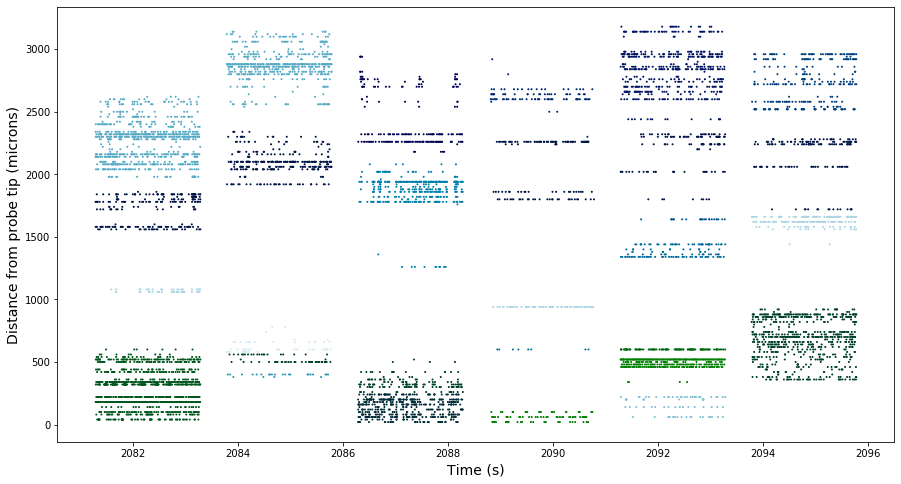

In [47]:
y_positions = session.units.loc[T.unit_id]['probe_vertical_position']
_, x_positions = np.unique(session.units.loc[T.unit_id]['probe_id'], return_inverse=True) 
_, colors = np.unique(session.units.loc[T.unit_id]['ecephys_structure_id'], return_inverse=True)

plt.figure(figsize=(15,8))
plt.scatter(x_positions * 2.5 + T.index.values, y_positions, c=colors, s=1, cmap='ocean')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Distance from probe tip (microns)', fontsize=14)

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.2:</b> Extract a matrix of units x times x trials

<p> This is useful for a lot of things.

</div>


In [48]:
bin_edges = np.arange(0,2,0.025) # 25 ms bins over a 2-second window
stimulus_presentation_ids = one_condition.index.values # select all the trials for one type
unit_ids = session.units[session.units.ecephys_structure_acronym.str.match('VIS')].index.values # select all the units in visual cortex

T = session.presentationwise_spike_counts(bin_edges, stimulus_presentation_ids, unit_ids)

In [49]:
T.head()

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 5, time_relative_to_stimulus_onset: 5, unit_id: 5)>
array([[[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 3, 0, 0],
        [1, 0, 0, 0, 0],
        [4, 1, 0, 0, 0],
        [9, 2, 0, 0, 1]],

       [[0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [1, 3, 1, 0, 0],
        [0, 0, 1, 2, 0],
        [0, 2, 0, 0, 1],
        [0, 1, 0, 0, 2]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3873 ... 31082
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.0125 ... 0.1125
  * unit_id                          (unit_i

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
<h3>xarray</h3>

This has returned a new (to this notebook) data structure, the `xarray.DataArray`. You can think of this as similar to a 3D <code>pandas.DataFrame</code>, or as a <code>numpy.ndarray</code> with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:

- to pandas: <code>histograms.to_dataframe()</code> produces a multiindexed dataframe
- to numpy: <code>histograms.values</code> gives you access to the underlying numpy array

</div>

Let's do something cool with it!

Text(0, 0.5, 'Unit #')

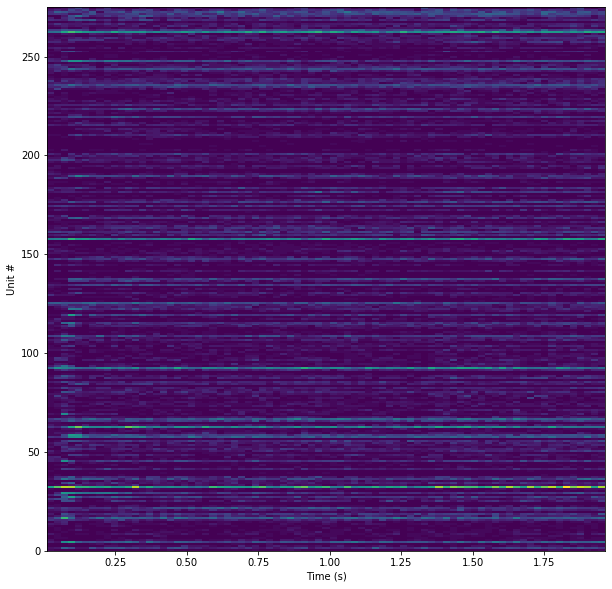

In [50]:
psth = T.mean(dim='stimulus_presentation_id')

plt.figure(figsize=(10,10))
plt.imshow(psth.T, aspect='auto', 
           extent = (T.time_relative_to_stimulus_onset.min(),
                     T.time_relative_to_stimulus_onset.max(),
                     0, T.unit_id.size))
plt.xlabel('Time (s)')
plt.ylabel('Unit #')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 25px; padding-right: 25px; padding-top:25px; padding-bottom:25px; background: #F0FAFF; ">
<h3>Summary</h3>

That's the end of the tutorial! So far, you've learned how to:
* Configure a cache for storing data locally (or in the cloud)
* Browse through available sessions and select one to analyze
* See which areas were recorded and where the units for each area are located along the probe
* Load the spike times for one unit
* Find information about the stimuli that were presented
* Use more advanced methods to access spike times across multiple units or multiple stimulus presentations

There's plenty more to learn, so we recommend checking out [this example notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html) to find out how to access more features of the data, such as:
* Mean waveforms for each unit
* LFP data
* Running speed
* Current source density plots

</div>